## **Part 1: Pretext Tasks**

In [1]:
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision.datasets import CIFAR10

In [2]:
class Classifier1(nn.Module):
  def __init__(self, out=10):
    super(Classifier1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5), stride=1)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), stride=1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.fc = nn.Linear(250, 20)
    self.out = nn.Linear(20, out)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc(x))
    return self.out(x)

def init_weights(layer):
  if isinstance(layer, nn.Linear):
    nn.init.kaiming_normal_(layer.weight.data)
    nn.init.zeros_(layer.bias.data)

In [3]:
dataset = CIFAR10(root='/content/drive/My Drive/Colab Notebooks/CIFAR/', download=False, train=True)

original = dataset.data
original = original / 255

labels = np.array(dataset.targets)
print(labels.shape)

del dataset

train_images = []
train_labels = []
original_data = []
for i in range(10):
  train_labels.append(labels[labels == i][-50:])
  train_images.append(original[labels == i][-50:])
  original_data.append(original[labels == i][:-50])

train_images, train_labels = np.asarray(train_images), np.asarray(train_labels)
train_images = (train_images - 0.5) / 0.5
train_images = train_images.reshape((500, 32, 32, 3))

train_labels = train_labels.reshape((500,))

original_data = np.asarray(original_data)
original_data = original_data.reshape((49500, 32, 32, 3))

del original

print("checking the range of the values of pixel in images:")
print(np.min(train_images), np.max(train_images))

print("shape of the new training data:")
print(train_images.shape, train_labels.shape)

print("shape of the remaining data:")
print(original_data.shape)

(50000,)
checking the range of the values of pixel in images:
-1.0 1.0
shape of the new training data:
(500, 32, 32, 3) (500,)
shape of the remaining data:
(49500, 32, 32, 3)


I have used the dataset available from the PyTorch library. Since I had the data downloaded already, my *'download'* parameter is *False*

In [4]:
# class 0
labels_0 = np.zeros((49500,))

Text(0.5, 1.0, 'Flipped Images')

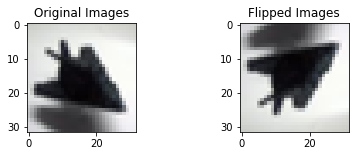

In [5]:
# class 1
def flipHor(data):
  return np.flip(data, axis=1)

images_1 = flipHor(original_data)
labels_1 = np.ones_like(labels_0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,2))
ax1.imshow(original_data[0])
ax1.set_title("Original Images")
ax2.imshow(images_1[0])
ax2.set_title("Flipped Images")

Text(0.5, 1.0, 'Flipped Images')

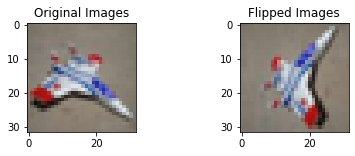

In [6]:
# class 2
def rotate(data):
  return np.rot90(data, k=1, axes=(1, 2))

images_2 = rotate(original_data)
labels_2 = np.ones_like(labels_0) + 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,2))
ax1.set_title("Original Images")
ax1.imshow(original_data[1])
ax2.imshow(images_2[1])
ax2.set_title("Flipped Images")

In [7]:
# Create one big dataset
del images_1, images_2

augmented_data = np.concatenate((original_data, flipHor(original_data), rotate(original_data)))
augmented_data = (augmented_data - 0.5) / 0.5

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Classifier1(3)
net.apply(init_weights)
net.to(device)

print(net)

err_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Classifier1(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=250, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=3, bias=True)
)


In [9]:
# Data loader for augmented data
aug_loader = torch.utils.data.DataLoader(utils.TensorDataset(torch.Tensor(augmented_data).permute((0, 3, 2, 1)).to(device), 
                                                               torch.tensor(np.concatenate((labels_0, labels_1, labels_2)), dtype=torch.long).to(device)), batch_size=512, shuffle=True)

del labels_1, labels_2, labels_0

In [10]:
# Training the network
epochs = 100

for e in range(1, epochs+1):
  train_loss_epoch = 0
  for row, target in aug_loader:
    # set the gradients to zero as PyTorch automatically accumulates gradients
    optimizer.zero_grad()

    outs = net(row)

    # calculate loss
    loss = err_func(outs, target)
    
    # Calculate gradients
    loss.backward()
    
    # Propagate gradients back
    optimizer.step()
    
    train_loss_epoch += loss.item()
  else:
    err = train_loss_epoch/len(augmented_data)
    if e%10 == 0:
      print("EPOCH: ", e)
      print(f"   Overall Training loss for epoch {e}: {err}")

EPOCH:  10
   Overall Training loss for epoch 10: 0.001311662094360249
EPOCH:  20
   Overall Training loss for epoch 20: 0.0012109674287564827
EPOCH:  30
   Overall Training loss for epoch 30: 0.0011614132232537575
EPOCH:  40
   Overall Training loss for epoch 40: 0.0011291170654072103
EPOCH:  50
   Overall Training loss for epoch 50: 0.0011084174574023545
EPOCH:  60
   Overall Training loss for epoch 60: 0.0010901944785808473
EPOCH:  70
   Overall Training loss for epoch 70: 0.001077479645660028
EPOCH:  80
   Overall Training loss for epoch 80: 0.0010685056979808742
EPOCH:  90
   Overall Training loss for epoch 90: 0.0010611175364918179
EPOCH:  100
   Overall Training loss for epoch 100: 0.0010531718923587991


In [11]:
torch.save(net.state_dict(), 'pretext.pt')

## **Part 2: The Baseline**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Classifier1().to(device)
net.apply(init_weights)

print(net)

err_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Classifier1(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=250, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=10, bias=True)
)


In [13]:
trainer = utils.DataLoader(utils.TensorDataset(torch.Tensor(train_images).permute((0, 3, 2, 1)).to(device), 
                                               torch.tensor(train_labels, dtype=torch.long).to(device)), batch_size=512, shuffle=True)

In [14]:
dataset = CIFAR10(root='/content/drive/My Drive/Colab Notebooks/CIFAR/', download=False, train=False)

test_data = dataset.data / 255
test_data = (test_data - 0.5) / 0.5

test_labels = np.array(dataset.targets)

test_loader = utils.DataLoader(utils.TensorDataset(torch.Tensor(test_data).permute((0, 3, 2, 1)).to(device), 
                                               torch.tensor(test_labels, dtype=torch.long).to(device)), batch_size=512, shuffle=False)

test_n = len(test_data)

del dataset, test_labels, test_data

In [15]:
# Training the network
epochs = 10000
val_acc_base = []
for e in range(1, epochs+1):
  train_loss_epoch = 0
  val_loss = 0
  correct = 0
  net.train()
  for row, target in trainer:
    # set the gradients to zero as PyTorch automatically accumulates gradients
    optimizer.zero_grad()
    outs = net(row)

    # calculate loss
    loss = err_func(outs, target)
    
    # Calculate gradients
    loss.backward()
    
    # Propagate gradients back
    optimizer.step()
    
    train_loss_epoch += loss.item()
  if e%100 == 0:
    net.eval()
    with torch.no_grad():
      for data, target in test_loader:

          output = net(data)
          val_loss += err_func(output, target).item()

          # prediction will be the class with highest probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.view_as(pred)).sum()

    acc = 100 * torch.true_divide(correct, test_n)
    val_acc_base.append(acc.item())
    err = train_loss_epoch/len(trainer)
    
    print("EPOCH:{eps}  |       accuracy:{acc}  |         train_loss:{ls}".format(eps = e, acc = round(acc.item(), 4), ls=err))

import pickle
pickle.dump(val_acc_base, open("val_acc_base.pkl", "wb" ) )

EPOCH:100  |       accuracy:33.86  |         train_loss:0.5603975653648376
EPOCH:200  |       accuracy:32.13  |         train_loss:0.028788011521100998
EPOCH:300  |       accuracy:32.04  |         train_loss:0.006609014235436916
EPOCH:400  |       accuracy:31.94  |         train_loss:0.002960699377581477
EPOCH:500  |       accuracy:32.02  |         train_loss:0.0016969479620456696
EPOCH:600  |       accuracy:32.03  |         train_loss:0.001104719121940434
EPOCH:700  |       accuracy:31.98  |         train_loss:0.0007773861871100962
EPOCH:800  |       accuracy:31.9  |         train_loss:0.0005768202827312052
EPOCH:900  |       accuracy:31.92  |         train_loss:0.0004446880775503814
EPOCH:1000  |       accuracy:32.01  |         train_loss:0.00035280667361803353
EPOCH:1100  |       accuracy:31.98  |         train_loss:0.00028637060313485563
EPOCH:1200  |       accuracy:32.05  |         train_loss:0.00023674400290474296
EPOCH:1300  |       accuracy:32.04  |         train_loss:0.0001986

No handles with labels found to put in legend.


<function matplotlib.pyplot.show>

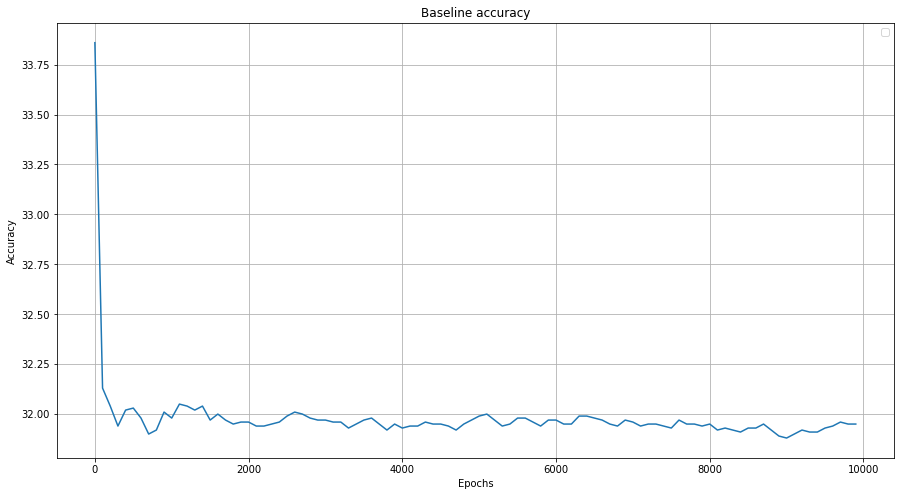

In [24]:
eps = np.arange(1, 10001, 100)
fig = plt.figure(figsize=(15,8))
plt.plot(eps, val_acc_base)
plt.title("Baseline accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show

## Part 3: Transfer Learning

In [16]:
pretext = torch.load('pretext.pt')
pretext.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc.weight', 'fc.bias', 'out.weight', 'out.bias'])

In [17]:
class Classifier3(nn.Module):
  def __init__(self):
    super(Classifier3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5), stride=1)
    self.conv1.weight, self.conv1.bias = nn.Parameter(pretext['conv1.weight']), nn.Parameter(pretext['conv1.bias'])

    self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), stride=1)
    self.conv2.weight, self.conv2.bias = nn.Parameter(pretext['conv2.weight']), nn.Parameter(pretext['conv2.bias'])

    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)

    self.fc = nn.Linear(250, 20)
    self.fc.weight, self.fc.bias = nn.Parameter(pretext['fc.weight']), nn.Parameter(pretext['fc.bias'])

    self.out = nn.Linear(20, 10)
    nn.init.kaiming_normal_(self.out.weight)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc(x))
    x = self.out(x)
    return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

final_net = Classifier3().to(device)
print(final_net)
final_net.train()

err_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_net.parameters())

optimizer = optim.Adam([{'params': final_net.conv1.parameters(), 'lr': 1e-5},
                        {'params': final_net.conv2.parameters(), 'lr': 1e-5},
                        {'params': final_net.fc.parameters(), 'lr': 1e-5},
                        {'params': final_net.out.parameters()}])

Classifier3(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=250, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=10, bias=True)
)


In [19]:
# Training the network
epochs = 10000
val_acc_tl = []
for e in range(1, epochs+1):
  train_loss_epoch = 0
  val_loss = 0
  correct = 0
  final_net.train()
  for row, target in trainer:
    # set the gradients to zero as PyTorch automatically accumulates gradients
    optimizer.zero_grad()
    outs = final_net(row)

    # calculate loss
    loss = err_func(outs, target)
    
    # Calculate gradients
    loss.backward()
    
    # Propagate gradients back
    optimizer.step()
    
    train_loss_epoch += loss.item()
  if e%100 == 0:
    final_net.eval()
    with torch.no_grad():
      for data, target in test_loader:

          output = final_net(data)
          val_loss += err_func(output, target).item()

          # prediction will be the class with highest probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.view_as(pred)).sum()
    acc = 100 * torch.true_divide(correct, test_n)
    val_acc_tl.append(acc.item())
    err = train_loss_epoch/len(trainer)
    
    print("EPOCH:{eps}  |       accuracy:{acc}  |         train_loss:{ls}".format(eps = e, acc = round(acc.item(), 4), ls=err))

import pickle
pickle.dump(val_acc_tl, open("val_acc_tl.pkl", "wb" ) )

EPOCH:100  |       accuracy:14.89  |         train_loss:2.656346082687378
EPOCH:200  |       accuracy:20.29  |         train_loss:2.2088444232940674
EPOCH:300  |       accuracy:24.36  |         train_loss:1.9636163711547852
EPOCH:400  |       accuracy:26.92  |         train_loss:1.8093794584274292
EPOCH:500  |       accuracy:29.11  |         train_loss:1.700170874595642
EPOCH:600  |       accuracy:30.53  |         train_loss:1.6171190738677979
EPOCH:700  |       accuracy:31.72  |         train_loss:1.5499262809753418
EPOCH:800  |       accuracy:32.59  |         train_loss:1.4922658205032349
EPOCH:900  |       accuracy:33.16  |         train_loss:1.4423142671585083
EPOCH:1000  |       accuracy:33.46  |         train_loss:1.3977539539337158
EPOCH:1100  |       accuracy:33.56  |         train_loss:1.35591459274292
EPOCH:1200  |       accuracy:34.03  |         train_loss:1.3159003257751465
EPOCH:1300  |       accuracy:34.27  |         train_loss:1.2785204648971558
EPOCH:1400  |       accur

No handles with labels found to put in legend.


<function matplotlib.pyplot.show>

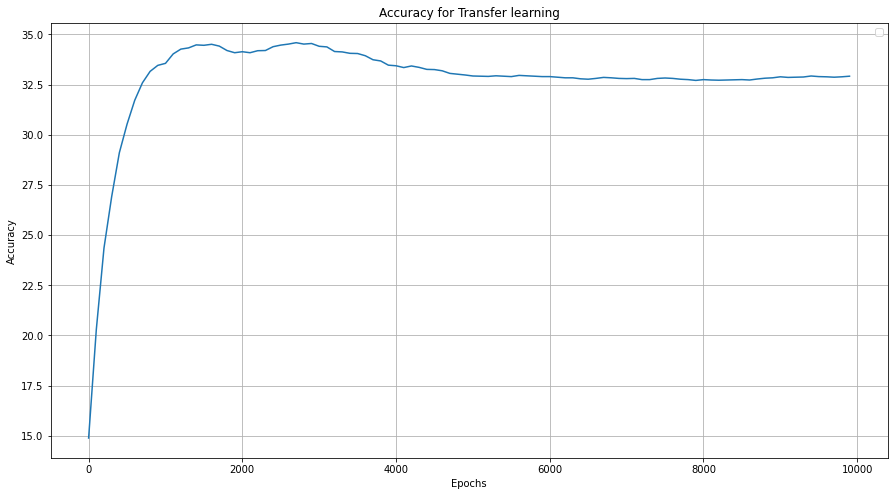

In [25]:
eps = np.arange(1, 10001, 100)
fig = plt.figure(figsize=(15,8))
plt.plot(eps, val_acc_tl)
plt.title("Accuracy for Transfer learning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show

In [20]:
import pickle
val_acc_tl = pickle.load(open("val_acc_tl.pkl", "rb" ))
val_acc_base = pickle.load(open("val_acc_base.pkl", "rb" ))

<function matplotlib.pyplot.show>

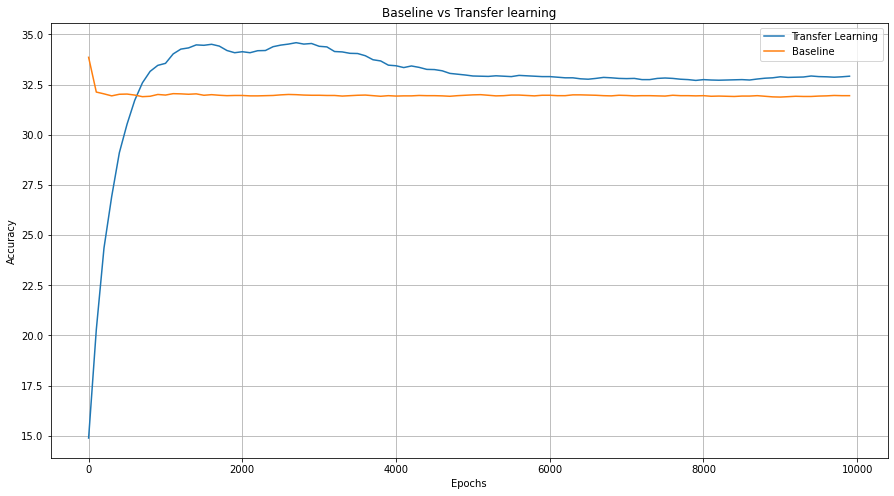

In [22]:
eps = np.arange(1, 10001, 100)
fig = plt.figure(figsize=(15,8))
plt.plot(eps, val_acc_tl, label="Transfer Learning")
plt.plot(eps, val_acc_base, label="Baseline")
plt.title("Baseline vs Transfer learning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show

As we can from the above plot that model trained using the concept of transfer learning performs better than the base line model. This is because we initialized the model parameters with the parameters of a classifier trained on a bogus data. This is called self-supervised learning.